# Kaggle 2017 March Madness Tourny

In [7]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

#Required for other guy's logistic regression 
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

#Additional to Implement my Logistic Regression
#from patsy import dmatrices 
#from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [8]:
file_path = 'D:\_data_science_data\\2017_march_madness\\'

In [9]:
reg_detailed_results = pd.read_csv(file_path+"RegularSeasonDetailedResults.csv")
reg_detailed_results[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
5,2003,11,1458,81,1186,55,H,0,26,57,...,11,12,17,6,22,8,19,4,3,25


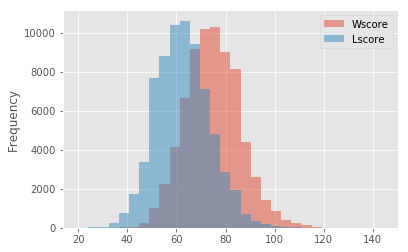

In [10]:
reg_detailed_results[['Wscore','Lscore']].plot.hist(alpha = 0.5, bins =30, stacked = False)

In [25]:
#def split_seed(Seed):
#    return (str(Seed[0]),int(Seed[1:3]))
#print(type(split_seed('z16a')))
#
#def get_seed_num(Seed):
#    return split_seed(Seed)[1]
#def get_seed_reg(Seed):
#    return split_seed(Seed)[0]
#print(set(seeds['Seed']))
#seeds['region'] = seeds['Seed'].apply(get_seed_reg)
#seeds['num_seed'] = seeds['Seed'].apply(get_seed_num)
#seeds.drop(labels=['Seed'], inplace=True, axis=1)
#print(seeds[:6])

#win_seeds = seeds.rename(columns={'Team':'Wteam', 'num_seed':'win_seed','region':'win_region'})
#loss_seeds = seeds.rename(columns={'Team':'Lteam', 'num_seed':'loss_seed','region':'loss_region'})

#print(win_seeds[:3])
#print(loss_seeds[:3])

In [14]:
tourn_full = pd.read_csv(file_path+"TourneyDetailedResults.csv")
tourn_full[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
5,2003,136,1163,58,1140,53,N,0,17,52,...,17,11,13,15,26,11,11,8,4,22


# Other Guy's Logistic Regression Example

In [26]:
df_seeds = pd.read_csv(file_path+"TourneySeeds.csv")
seeds[:6]

,Season,Team,region,num_seed
0,1985,1207,W,1
1,1985,1210,W,2
2,1985,1228,W,3
3,1985,1260,W,4
4,1985,1374,W,5
5,1985,1208,W,6


In [27]:
df_tour = pd.read_csv(file_path+"TourneyCompactResults.csv")
tourn_compact[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
5,1985,136,1246,66,1449,58,N,0


In [28]:
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)

In [29]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [30]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [31]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

In [32]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))

In [33]:
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)

In [34]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5536, with best C: 0.01


In [35]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

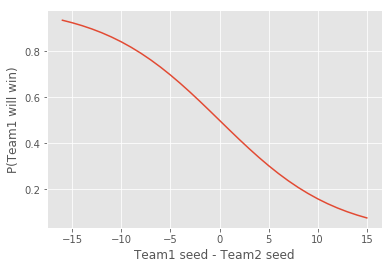

In [36]:
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [37]:
df_sample_sub = pd.read_csv(file_path + 'sample_submission.csv')
n_test_games = len(df_sample_sub)
#df_sample_sub[:6]

In [38]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))
#We loop over each row in the sample_submission.csv file. For each row, we extract the year and the teams playing. 
#We then look up the seeds for each of those teams in that season. Finally we add the seed difference to an array.

In [39]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.id)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.Team == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.Team == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [40]:
preds = clf.predict_proba(X_test)[:,1]

In [41]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.pred = clipped_preds
df_sample_sub.head()

,id,pred
0,2013_1103_1107,0.622432
1,2013_1103_1112,0.268988
2,2013_1103_1125,0.458439
3,2013_1103_1129,0.541561
4,2013_1103_1137,0.458439


In [42]:
df_sample_sub.to_csv('other_guys_logreg_on_seed.csv', index=False)